In [ ]:
import tensorflow as tf
from zipfile import ZipFile
import os, glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from zipfile import ZipFile
import matplotlib.pyplot as plt
import pickle
import PIL
from PIL import Image
from math import exp, tanh
from tokenize import Exponent
from enum import Enum
from io import BytesIO, StringIO
import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/drive/')

file_name = "drive/MyDrive/BreakHis/data"

DATADIR = "drive/MyDrive/BreakHis/data/train"

import pathlib

data_dir = pathlib.Path(DATADIR)

image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

Mounted at /content/drive/
7828


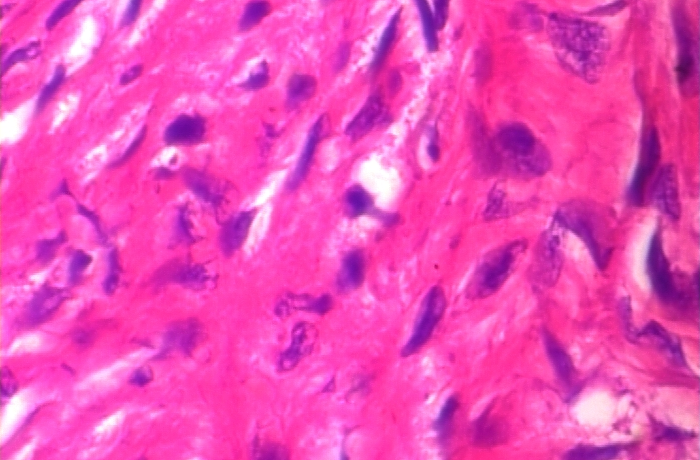

In [ ]:
benign = list(data_dir.glob('benign/*'))
PIL.Image.open(str(benign[0]))

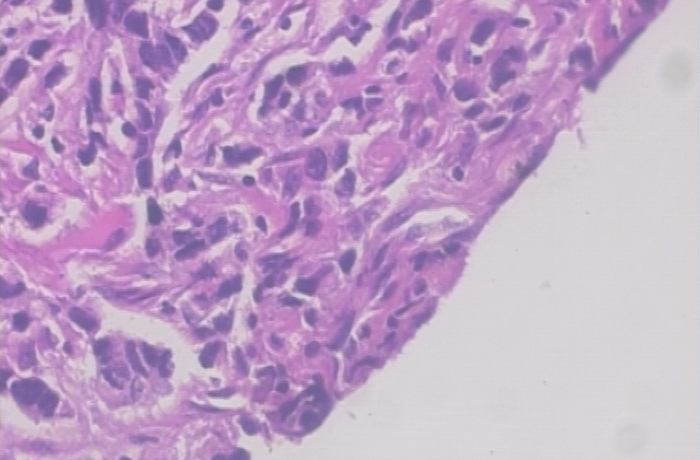

In [ ]:
malignant = list(data_dir.glob('malignant/*'))
PIL.Image.open(str(malignant[0]))

In [ ]:
image_width = 180
image_height = 180
batch_size = 32

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(image_height,image_width)
)

Found 7828 files belonging to 2 classes.
Using 6263 files for training.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(image_height,image_width),
    batch_size=batch_size
)

Found 7828 files belonging to 2 classes.
Using 1565 files for validation.


In [ ]:
class_names = train_dataset.class_names

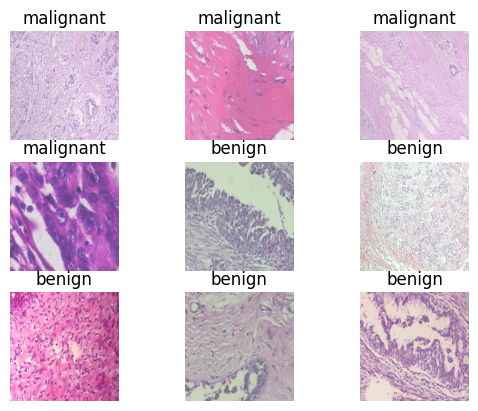

In [ ]:
import matplotlib.pyplot as plt
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break



(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalisation_layer =  tf.keras.layers.Rescaling(1./255)

In [ ]:
normalise_dataset = train_dataset.map(lambda x,y: (normalisation_layer(x), y))

In [ ]:
image_batch, labels_batch = next(iter(normalise_dataset))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

In [ ]:
num_classes = len(class_names)

model = Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
epochs=10
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/10
196/196 [==============================] - 887s 3s/step - loss: 0.5427 - accuracy: 0.7635 - val_loss: 0.5063 - val_accuracy: 0.7661
Epoch 2/10
196/196 [==============================] - 250s 1s/step - loss: 0.4434 - accuracy: 0.8229 - val_loss: 0.4285 - val_accuracy: 0.8460
Epoch 3/10
196/196 [==============================] - 241s 1s/step - loss: 0.4233 - accuracy: 0.8351 - val_loss: 0.4110 - val_accuracy: 0.8460
Epoch 4/10
196/196 [==============================] - 252s 1s/step - loss: 0.4261 - accuracy: 0.8296 - val_loss: 0.3885 - val_accuracy: 0.8556
Epoch 5/10
196/196 [==============================] - 246s 1s/step - loss: 0.3935 - accuracy: 0.8490 - val_loss: 0.3862 - val_accuracy: 0.8460
Epoch 6/10
196/196 [==============================] - 248s 1s/step - loss: 0.3836 - accuracy: 0.8512 - val_loss: 0.3651 - val_accuracy: 0.8607
Epoch 7/10
196/196 [==============================] - 247s 1s/step - loss: 0.3733 - accuracy: 0.8577 - val_loss: 0.3706 - val_accuracy: 0.8518

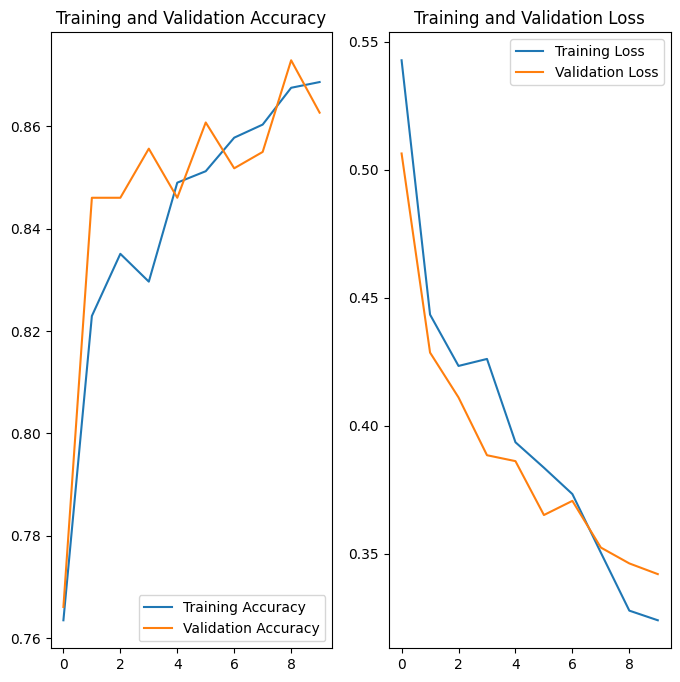

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal",
                          input_shape=(image_height,
                                       image_width,
                                       3)),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

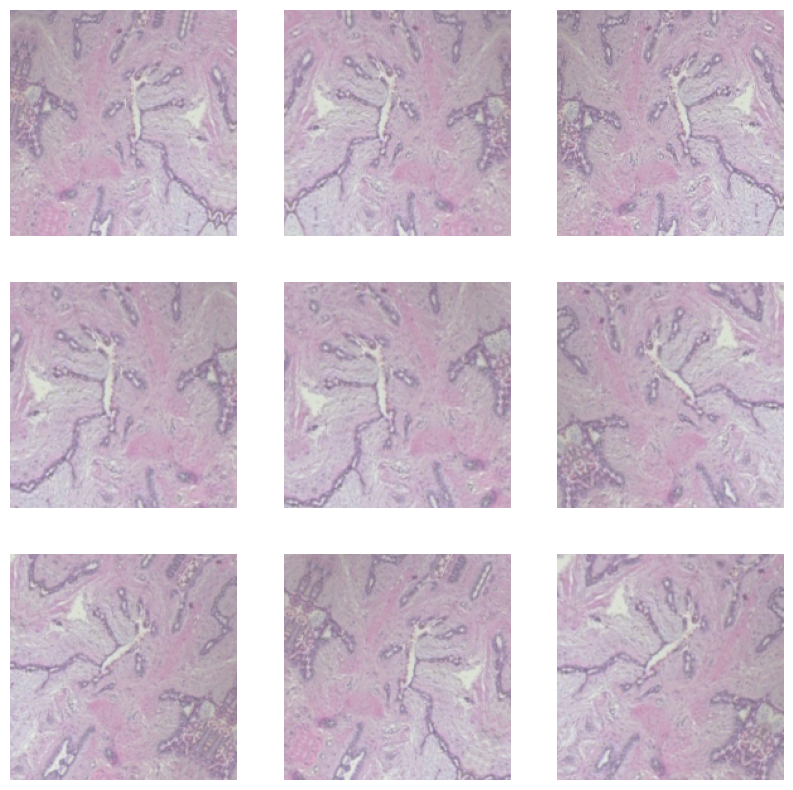

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
model = Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [ ]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

In [ ]:
epochs = 15
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/15
3/3 [==============================] - 8s 2s/step - loss: 1.2916 - accuracy: 0.4203 - val_loss: 0.7646 - val_accuracy: 0.6471
Epoch 2/15
3/3 [==============================] - 3s 1s/step - loss: 0.4862 - accuracy: 0.7971 - val_loss: 0.6558 - val_accuracy: 0.6471
Epoch 3/15
3/3 [==============================] - 3s 1s/step - loss: 0.4566 - accuracy: 0.7971 - val_loss: 0.4835 - val_accuracy: 0.6471
Epoch 4/15
3/3 [==============================] - 4s 1s/step - loss: 0.2990 - accuracy: 0.8116 - val_loss: 0.2757 - val_accuracy: 0.9412
Epoch 5/15
3/3 [==============================] - 3s 807ms/step - loss: 0.1555 - accuracy: 0.9855 - val_loss: 0.0861 - val_accuracy: 1.0000
Epoch 6/15
3/3 [==============================] - 3s 768ms/step - loss: 0.0327 - accuracy: 1.0000 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 7/15
3/3 [==============================] - 3s 793ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 8/15
3/3 [================

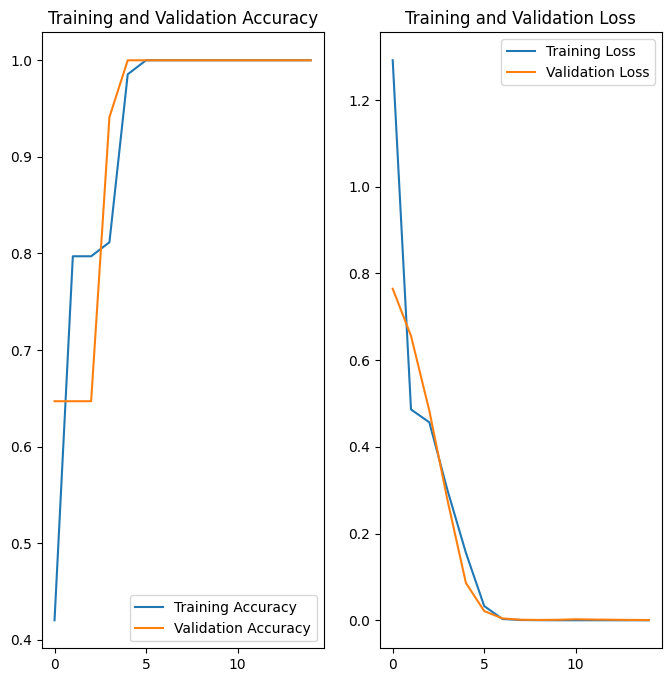

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
DATA_DIR = "drive/MyDrive/BreakHis/data/test/benign/SOB_B_A-14-22549AB-100-001.png"

In [ ]:
data_dir = pathlib.Path(DATA_DIR)


In [ ]:
img = tf.keras.utils.load_img(
    data_dir, target_size=(image_height, image_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 303ms/step
This image most likely belongs to benign with a 99.80 percent confidence.


In [ ]:
DATA_DIR = "drive/MyDrive/BreakHis/data/train/malignant/SOB_M_DC-14-10926-100-007.png"
data_dir = pathlib.Path(DATA_DIR)


In [ ]:
img = tf.keras.utils.load_img(
    data_dir, target_size=(image_height, image_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 0s 32ms/step
This image most likely belongs to malignant with a 78.22 percent confidence.
